In [1]:
# Import standard dependencies
import cv2
import os
import random
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [4]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')

In [5]:
# Make the directories
os.makedirs(POS_PATH)
os.makedirs(NEG_PATH)
os.makedirs(ANC_PATH)

In [6]:
for directory in os.listdir('lfw'):
    for file in os.listdir(os.path.join('lfw', directory)):
        EX_PATH = os.path.join('lfw', directory, file)
        NEW_PATH = os.path.join(NEG_PATH, file)
        os.replace(EX_PATH, NEW_PATH)

In [7]:
import uuid

In [8]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))

'data\\anchor\\3d068e34-3cb3-11ed-a53d-e133b804f6ef.jpg'

In [9]:
# Establish a connection to the webcam
cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise IOError("Cannot open webcam")

while True:

    ret, frame = cap.read()
   
    # Cut down frame to 250x250px
    frame = frame[120:120+250,200:200+250, :]
    
    # Collect anchors 
    if cv2.waitKey(1) & 0XFF == ord('a'):
        # Create the unique file path 
        imgname = os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out anchor image
        cv2.imwrite(imgname, frame)
    
    # Collect positives
    if cv2.waitKey(1) & 0XFF == ord('p'):
        # Create the unique file path 
        imgname = os.path.join(POS_PATH, '{}.jpg'.format(uuid.uuid1()))
        # Write out positive image
        cv2.imwrite(imgname, frame)
    
    # Show image back to screen
    cv2.imshow('Image Collection', frame)
    
    # Breaking gracefully
    if cv2.waitKey(1) & 0XFF == ord('q'):
        break
        
# Release the webcam
cap.release()
# Close the image show frame
cv2.destroyAllWindows()

In [11]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(300)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(300)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [12]:
dir_test = anchor.as_numpy_iterator()

In [13]:
print(dir_test.next())

b'data\\anchor\\5c392c02-3cb3-11ed-959c-e133b804f6ef.jpg'


In [14]:
def preprocess(file_path):
    
    # Read in image from file path
    byte_img = tf.io.read_file(file_path)
    # Load in the image 
    img = tf.io.decode_jpeg(byte_img)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100,100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return image
    return img

In [15]:
img = preprocess('data\\anchor\\5c392c02-3cb3-11ed-959c-e133b804f6ef.jpg')

In [16]:
img.numpy().max()

0.9992647

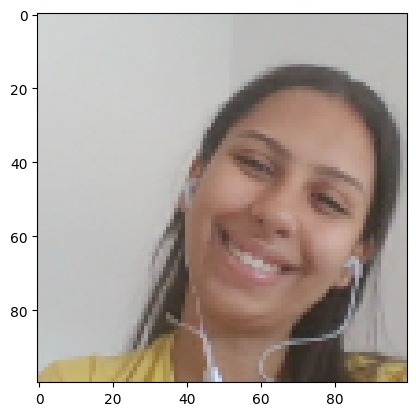

In [18]:
plt.imshow(img)

In [ ]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [19]:
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
data = positives.concatenate(negatives)

In [20]:
data

<ConcatenateDataset shapes: ((), (), ()), types: (tf.string, tf.string, tf.float32)>

In [21]:
samples = data.as_numpy_iterator()

In [22]:
exampple = samples.next()

In [23]:
exampple

(b'data\\anchor\\597ab80a-3cb3-11ed-be76-e133b804f6ef.jpg',
 b'data\\positive\\6d0f5cfa-3cb3-11ed-ac8d-e133b804f6ef.jpg',
 1.0)

In [24]:
def preprocess_twin(input_img, validation_img, label):
    return(preprocess(input_img), preprocess(validation_img), label)

In [25]:
res = preprocess_twin(*exampple)

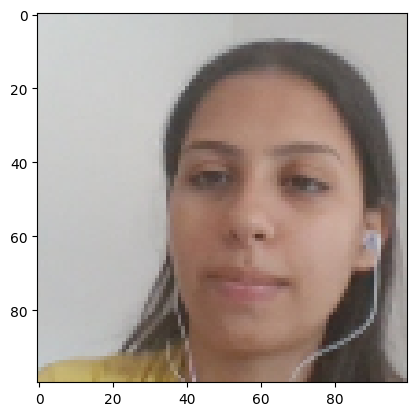

In [26]:
plt.imshow(res[1])

In [27]:
res[2]

1.0

In [28]:
# Build dataloader pipeline
data = data.map(preprocess_twin)
data = data.cache()
data = data.shuffle(buffer_size=1024)

In [29]:
# Training partition
train_data = data.take(round(len(data)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [30]:
# Testing partition
test_data = data.skip(round(len(data)*.7))
test_data = test_data.take(round(len(data)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)

In [31]:
inp = Input(shape=(105,105,3), name='input_image')

In [32]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [33]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [34]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [35]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [36]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [37]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [38]:
mod.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 105, 105, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 96, 96, 64)        19264     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 48, 48, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 42, 42, 128)       401536    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 21, 21, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 18, 18, 128)       262272    
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 9, 9, 128)         0 

In [39]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D(64, (2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D(64, (2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D(64, (2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    
    return Model(inputs=[inp], outputs=[d1], name='embedding')

In [40]:
embedding = make_embedding()

In [41]:
embedding.summary()

Model: "embedding"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_image (InputLayer)     [(None, 100, 100, 3)]     0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 91, 91, 64)        19264     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 46, 46, 64)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 40, 40, 128)       401536    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 20, 20, 128)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 17, 17, 128)       262272    
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 9, 9, 128)         0 

In [42]:
# Siamese L1 Distance class
class L1Dist(Layer):
    
    # Init method - inheritance
    def __init__(self, **kwargs):
        super().__init__()
       
    # Magic happens here - similarity calculation
    def call(self, input_embedding, validation_embedding):
        return tf.math.abs(input_embedding - validation_embedding)

In [43]:
l1 = L1Dist()

In [44]:
l1(anchor_embedding, validation_embedding)

In [46]:
input_image = Input(name='input_img', shape=(100,100,3))
validation_image = Input(name='validation_img', shape=(100,100,3))

In [47]:
inp_embedding = embedding(input_image)
val_embedding = embedding(validation_image)

In [48]:
siamese_layer = L1Dist()

In [55]:
siamese_layer(inp_embedding, val_embedding)

<KerasTensor: shape=(None, 4096) dtype=float32 (created by layer 'l1_dist_1')>

In [49]:
distances = siamese_layer(inp_embedding, val_embedding)

In [50]:
classifier = Dense(1, activation='sigmoid')(distances)

In [51]:
classifier

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'dense_2')>

In [52]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [53]:
siamese_network.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_1 (L1Dist)              (None, 4096)         0           embedding[0][0]     

In [54]:
def make_siamese_model(): 
    
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100,100,3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100,100,3))
    
    # Combine siamese distance components
    siamese_layer = L1Dist()
    siamese_layer._name = 'distance'
    distances = siamese_layer(embedding(input_image), embedding(validation_image))
    
    # Classification layer 
    classifier = Dense(1, activation='sigmoid')(distances)
    
    return Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [56]:
siamese_model = make_siamese_model()

In [57]:
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
distance (L1Dist)               (None, 4096)         0           embedding[2][0]     

Training

In [58]:
binary_cross_loss = tf.losses.BinaryCrossentropy()

In [59]:
opt = tf.keras.optimizers.Adam(1e-4) # 0.0001

In [62]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

In [63]:
test_batch = train_data.as_numpy_iterator()

In [64]:
batch_1 = test_batch.next()

In [65]:
X = batch_1[:2]

In [66]:
y = batch_1[2]

In [67]:
y

array([1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0.],
      dtype=float32)

In [68]:
tf.losses.BinaryCrossentropy??

In [69]:
@tf.function
def train_step(batch):
    
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        X = batch[:2]
        # Get label
        y = batch[2]
        
        # Forward pass
        yhat = siamese_model(X, training=True)
        # Calculate loss
        loss = binary_cross_loss(y, yhat)
    print(loss)
        
    # Calculate gradients
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [70]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [71]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

In [76]:
EPOCHS = 30

In [77]:
train(train_data, EPOCHS)


 Epoch 1/30
16/16 [==============================] - 435s 27s/step
0.0009330551 0.7657658 0.9883721

 Epoch 2/30
16/16 [==============================] - 432s 27s/step
0.00046163594 0.91818184 0.99019605

 Epoch 3/30
16/16 [==============================] - 420s 26s/step
0.3804527 0.95652175 1.0

 Epoch 4/30
16/16 [==============================] - 460s 29s/step
0.048279427 0.9649123 1.0

 Epoch 5/30
16/16 [==============================] - 453s 28s/step
0.021149741 0.96875 0.96875

 Epoch 6/30
16/16 [==============================] - 428s 27s/step
0.031269286 0.9714286 0.99029124

 Epoch 7/30
16/16 [==============================] - 415s 26s/step
1.2487307e-05 0.9910714 0.9910714

 Epoch 8/30
16/16 [==============================] - 744s 48s/step
0.000118597396 0.9818182 1.0

 Epoch 9/30
16/16 [==============================] - 441s 28s/step
0.0 1.0 1.0

 Epoch 10/30
16/16 [==============================] - 466s 29s/step
0.28973603 0.981982 1.0

 Epoch 11/30
16/16 [==================

In [78]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [79]:
# Get a batch of test data
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [80]:
y_hat = siamese_model.predict([test_input, test_val])

In [81]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0]

In [82]:
y_true

array([1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0.],
      dtype=float32)

In [83]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [84]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result
m.result().numpy()

1.0

In [85]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true,yhat) 

print(r.result().numpy(), p.result().numpy())


1.0 1.0


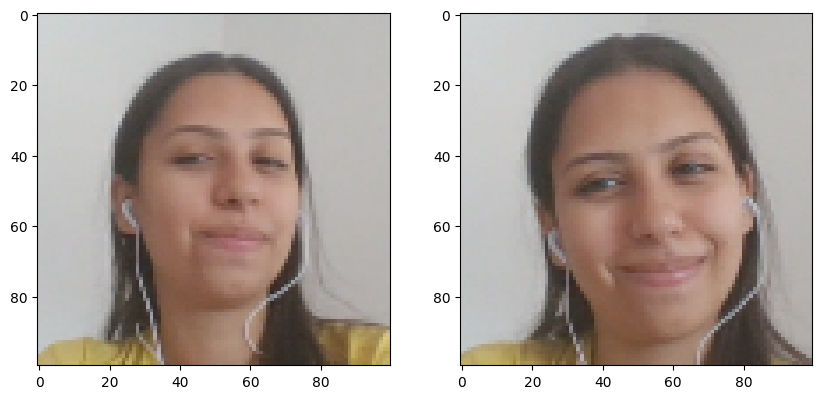

In [100]:
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[4])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[4])

# Renders cleanly
plt.show()

In [151]:
# Save weights
siamese_model.save('siamesemodelv2.h5')

In [141]:
L1Dist

__main__.L1Dist

In [142]:
# Reload model 
siamese_model = tf.keras.models.load_model('siamesemodelv2.h5',compile=False, 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [143]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

array([[6.5421574e-08],
       [6.8010104e-06],
       [9.9571228e-01],
       [4.9897764e-08],
       [9.9892724e-01],
       [3.2495409e-09],
       [5.9982335e-09],
       [1.8342048e-08]], dtype=float32)

In [144]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_img (InputLayer)          [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
validation_img (InputLayer)     [(None, 100, 100, 3) 0                                            
__________________________________________________________________________________________________
embedding (Functional)          (None, 4096)         38960448    input_img[0][0]                  
                                                                 validation_img[0][0]             
__________________________________________________________________________________________________
l1_dist_6 (L1Dist)              (None, 4096)         0           embedding[0][0]     

real time test

In [145]:
os.listdir(os.path.join('application_data', 'verification_images'))

['63308218-3cb3-11ed-ab14-e133b804f6ef.jpg',
 '634b8e1a-3cb3-11ed-b605-e133b804f6ef.jpg',
 '63993a82-3cb3-11ed-8269-e133b804f6ef.jpg',
 '64076be8-3cb3-11ed-adee-e133b804f6ef.jpg',
 '64c0eadc-3cb3-11ed-97b8-e133b804f6ef.jpg',
 '652b0898-3cb3-11ed-852d-e133b804f6ef.jpg',
 '654226a8-3cb3-11ed-8ba3-e133b804f6ef.jpg',
 '654e0f1c-3cb3-11ed-a6e8-e133b804f6ef.jpg',
 '65a64848-3cb3-11ed-bfd5-e133b804f6ef.jpg',
 '65d4c7ee-3cb3-11ed-a70e-e133b804f6ef.jpg',
 '660834c6-3cb3-11ed-aa7a-e133b804f6ef.jpg',
 '6631a9fa-3cb3-11ed-a298-e133b804f6ef.jpg',
 '6658bd24-3cb3-11ed-9fc7-e133b804f6ef.jpg',
 '667370ac-3cb3-11ed-bffa-e133b804f6ef.jpg',
 '66785a34-3cb3-11ed-97a4-e133b804f6ef.jpg',
 '66b09af0-3cb3-11ed-a6da-e133b804f6ef.jpg',
 '66c79a48-3cb3-11ed-9c6f-e133b804f6ef.jpg',
 '673d9490-3cb3-11ed-9f13-e133b804f6ef.jpg',
 '6753a78c-3cb3-11ed-abe6-e133b804f6ef.jpg',
 '6795fbb0-3cb3-11ed-8da6-e133b804f6ef.jpg',
 '679ad91e-3cb3-11ed-bc06-e133b804f6ef.jpg',
 '679fbb94-3cb3-11ed-a010-e133b804f6ef.jpg',
 '67abdd40

In [146]:
for image in os.listdir(os.path.join('application_data', 'verification_images')):
    validation_img = os.path.join('application_data', 'verification_images', image)
    print(validation_img)

application_data\verification_images\63308218-3cb3-11ed-ab14-e133b804f6ef.jpg
application_data\verification_images\634b8e1a-3cb3-11ed-b605-e133b804f6ef.jpg
application_data\verification_images\63993a82-3cb3-11ed-8269-e133b804f6ef.jpg
application_data\verification_images\64076be8-3cb3-11ed-adee-e133b804f6ef.jpg
application_data\verification_images\64c0eadc-3cb3-11ed-97b8-e133b804f6ef.jpg
application_data\verification_images\652b0898-3cb3-11ed-852d-e133b804f6ef.jpg
application_data\verification_images\654226a8-3cb3-11ed-8ba3-e133b804f6ef.jpg
application_data\verification_images\654e0f1c-3cb3-11ed-a6e8-e133b804f6ef.jpg
application_data\verification_images\65a64848-3cb3-11ed-bfd5-e133b804f6ef.jpg
application_data\verification_images\65d4c7ee-3cb3-11ed-a70e-e133b804f6ef.jpg
application_data\verification_images\660834c6-3cb3-11ed-aa7a-e133b804f6ef.jpg
application_data\verification_images\6631a9fa-3cb3-11ed-a298-e133b804f6ef.jpg
application_data\verification_images\6658bd24-3cb3-11ed-9fc7-e13

In [147]:
def verify(model, detection_threshold, verification_threshold):
    # Build results array
    results = []
    for image in os.listdir(os.path.join('application_data', 'verification_images')):
        input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
        validation_img = preprocess(os.path.join('application_data', 'verification_images', image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(os.path.join('application_data', 'verification_images'))) 
    verified = verification > verification_threshold
    
    return results, verified

OpenCV Real Time Verification

In [136]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()
    frame = frame[120:120+250,200:200+250, :]
    
    cv2.imshow('Verification', frame)
    
    # Verification trigger
    if cv2.waitKey(10) & 0xFF == ord('v'):

        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
        #Run verification
        results, verified = verify(siamese_model, 0.9, 0.7)
        print(verified)
    
    if cv2.waitKey(10) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

True


In [148]:
np.sum(np.squeeze(results) > 0.9)

45

In [149]:
45/58

0.7758620689655172